## Structuring for Uncertainty
### Summary 

In this notebook, I team up with FX Structurer Lennart Scholte to analyze a strategy for hedging against FX moves when planning for uncertain investments denominated in a foreign currency. As an example, we consider a US company looking to invest into a European subsidiary: the deal may not be certain - as it is pending various approvals - but the company may be looking to lock-in the current market levels especially given the trend of USD depreciating against the EUR. We consider a net zero premium strategy of entering into an option that is restructured into a forward once the deal gets approved and explore the economics under various potential future spot and vol scenarios.

The content of this notebook is split into:
* [1 - Let's get started with gs quant](#1---Let's-get-started-with-gs-quant)
* [2 - Spot and vol trends](#2---Spot-and-vol-trends)
* [3 - Options](#3---Options)
* [4 - Potential future scenarios](#4---Potential-future-scenarios)
* [5 - Restructuring into a Forward](#5---Restructuring-into-a-Forward)
* [What's New](#What's-New)

### 1 - Let's get started with gs quant
Start every session with authenticating with your unique client id and secret. If you don't have a registered app, create one [here](https://marquee.gs.com/s/developer/myapps/register). `run_analytics` scope is required for the functionality covered in this example. Below produced using gs-quant version 0.8.207.

In [1]:
from gs_quant.session import GsSession
GsSession.use(client_id=None, client_secret=None, scopes=('run_analytics', 'read_product_data')) 

### 2 - Spot and vol trends

Let's start by looking at spot and vol levels in the context of recent history. 

In [2]:
from dateutil.relativedelta import relativedelta
from gs_quant.datetime import business_day_offset
from gs_quant.data import Dataset
from datetime import date

date_end = business_day_offset(date.today(), -1, roll='forward')
date_start = business_day_offset(date_end - relativedelta(years=2), -1, roll='forward')

pair, term = 'EURUSD', '1y'
fx_eurusd = Dataset('FXSPOT_STANDARD').get_data(date_start, date_end, name=pair, fields=('spot',))[['spot']].spot
vol_eurusd = Dataset('FXIMPLIEDVOL_STANDARD').get_data(date_start, date_end, name=pair, tenor=term, deltaStrike='ATMS')[['impliedVolatility']].impliedVolatility * 100

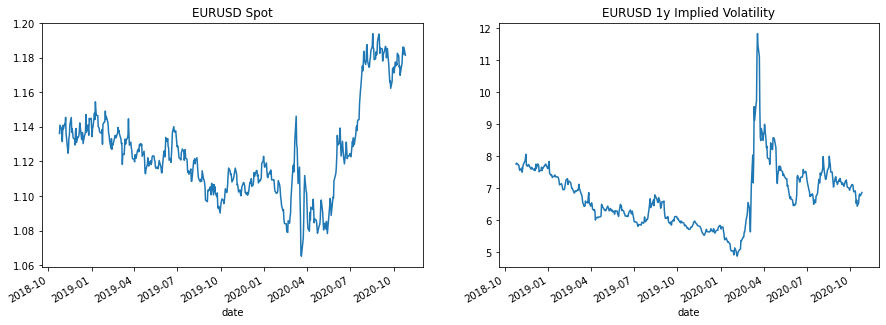

In [3]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

fx_eurusd.plot(title='EURUSD Spot', ax=axes[0])
vol_eurusd.plot(title='EURUSD 1y Implied Volatility', ax=axes[1])
plt.show()

As we can see in the left hand chart, USD has depreciated significantly against EUR year-to-date. Implied 1y volatility, on the other hand, has recently come down (although it's still rich compared to the beginning of the year). This means looking at options may be attractive to hedge against the dollar weakening further.

### 3 - Options

Assuming the company has a budget of 1.2 USD/EUR, let's look at how much a 1.2 call costs and how it compares to the equivalent historically.

In [4]:
from gs_quant.instrument import FXOption

budget = 1.2
call_option = FXOption(pair='EURUSD', expiration_date=term, option_type='Call', strike_price='s', 
                       premium_payment_date=term, premium_currency='USD').resolve(in_place=False)
print('spot vs budget: {:,.2%}'.format((call_option.strike_price / budget) - 1))

spot vs budget: -1.49%


As we can see above, at current market levels, the 1.20 strike for a 1Y EURUSD Call option is ~1.5% out-of-the-money spot.

Let's look at how the cost of trading a 1.5% OTMS spot call option compares to history. Note we are not calling `resolve()` on our `call_option` here which means it will re-strike to a new 1.5% OTMS option every day of the `HistoricalPricingContext`.

In [5]:
from gs_quant.markets import HistoricalPricingContext, PricingContext
from gs_quant.risk import DollarPrice, FXSpot
import pandas as pd

call_option = FXOption(pair='EURUSD', expiration_date=term, option_type='Call', strike_price='1.015*S', 
                       notional_amount=100e6, premium_payment_date=term, premium_currency='USD')

with HistoricalPricingContext(start=date_start, end=date_end, market_data_location='NYC'):
    inst = call_option.resolve(in_place=False)
    risks = call_option.calc((DollarPrice, FXSpot))

call_info = pd.DataFrame({d: i.as_dict() for d, i in inst.result().items()}).T
call_info['spot'] = risks[FXSpot]
call_info['premium usd %'] = -call_info.premium/call_info.notional_amount_other_currency * 100

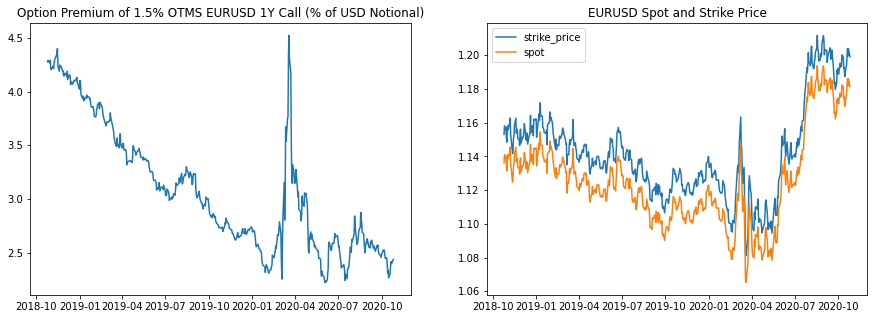

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
call_info['premium usd %'].plot(title='Option Premium of 1.5% OTMS EURUSD 1Y Call (% of USD Notional)', ax=axes[0])
call_info[['strike_price', 'spot']].plot(title='EURUSD Spot and Strike Price', ax=axes[1])
plt.show()

As we can see in the left chart, premium as a percentage of notional for a 1.5% OTMS call is relative lows compared to the last 2 years. 

Let's take this a step further and look at a quick grid across different strikes and tenors to better understand the sensitivity of the premium to different pricing parameters.

In [7]:
from gs_quant.markets.portfolio import Portfolio
import numpy as np

tenors = ['6m', '9m', '12m', '15m']
strikes = np.arange(1.17, 1.25, 0.01)

fxos = Portfolio([Portfolio([FXOption(pair='EURUSD', expiration_date=t, option_type='Call', strike_price=k, 
                                      notional_amount=100e6, premium_payment_date=t, premium_currency='USD') for t in tenors]) for k in strikes])
fxos.resolve()
call_grid = pd.DataFrame([[-i.premium / i.notional_amount_other_currency for i in p.priceables] for p in fxos.priceables], index=strikes, columns=tenors)

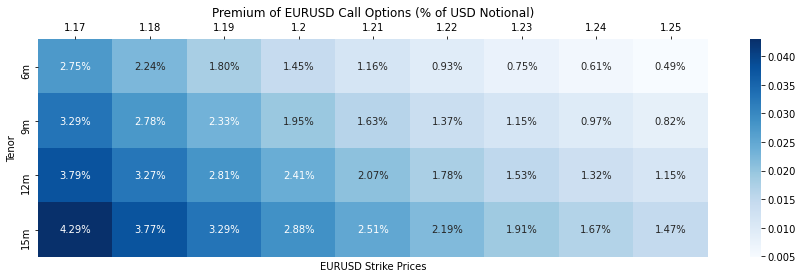

In [8]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(15, 4))
ax = sns.heatmap(call_grid.apply(pd.to_numeric).T, annot=True, fmt=',.2%', cmap='Blues')
ax.set(ylabel='Tenor', xlabel='EURUSD Strike Prices', title='Premium of EURUSD Call Options (% of USD Notional)')
ax.xaxis.tick_top()

### 4 - Potential future scenarios

As the company gets certainty about moving forward with the project, it might look to restructure the call option above into a forward to secure a rate.

To get a better sense of the economics of a possible restructuring, let's look at how the option carries and how the mark-to-market may vary with various possible levels of FX spot and implied vol.

Let's start with the static decay of the option over time: we can use `CarryScenario` to roll forward in time assuming that all market parameters, including the FX spot, remain constant (`roll_to_fwds=False` means roll to spot).

In [9]:
from gs_quant.risk import CarryScenario

# we set premium to 0 s.t. day-1 MtM is equal to the premium (as opposed to zero)
call_option = FXOption(pair=pair, expiration_date=term, option_type='Call', strike_price=budget, 
                       notional_amount=100e6, premium_payment_date=term, premium_currency='USD', premium=0).resolve(in_place=False)

future_dates = pd.bdate_range(date_end, call_option.expiration_date, freq='W').date.tolist()
roll_to_spot = {}
with PricingContext(is_batch=True, market_data_location='NYC'):
    for d in future_dates:
        with CarryScenario(date=d, roll_to_fwds=False):
            roll_to_spot[d] = call_option.dollar_price()
            
static_roll = pd.Series({d: p.result() for d, p in roll_to_spot.items()})

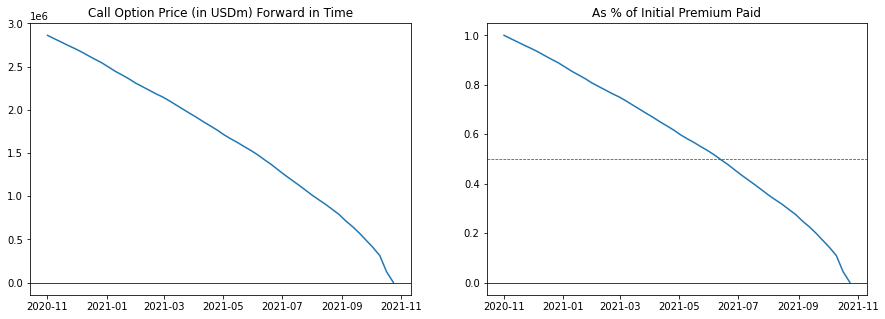

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
static_roll.plot(title='Call Option Price (in USDm) Forward in Time', ax=axes[0])
axes[0].axhline(y=0, linestyle='-', lw=0.75, color='black')
(static_roll/static_roll.iloc[0]).plot(title='As % of Initial Premium Paid', ax=axes[1])
axes[1].axhline(y=0, linestyle='-', lw=0.75, color='black')
axes[1].axhline(y=.5, linestyle='--', lw=0.75, color='red')
plt.show()

As we can see above, in about 7m from now, the time value of the option is still about 50% of the deferred premium payable, which can therefore be recouped when restructuring it into a forward.

Let's now see how the option may behave with different levels of spot and implied volatility over time by adding spot and vol shocks on top of the above `CarryScenario`.

In [11]:
tenors = ['1b', '3m', '6m', '9m', '1y']
vol_bumps = np.arange(-5, 7.5, 2.5) / 100
spot_range = np.arange(1.10, 1.27, 0.01)

In [12]:
from gs_quant.risk import MarketDataPattern, MarketDataShock, MarketDataShockBasedScenario,MarketDataShockType
from collections import defaultdict
call_res = defaultdict(lambda: defaultdict(dict))

with PricingContext(market_data_location='NYC', is_batch=True):
    for t in tenors:
        for s in spot_range:
            for v in vol_bumps:
                scenario = MarketDataShockBasedScenario(
                    shocks = {MarketDataPattern('FX', 'USD/EUR'): MarketDataShock(MarketDataShockType.Override, s),
                              MarketDataPattern('FX Vol', mkt_asset='USD/EUR', mkt_class='ATM Vol'): MarketDataShock(MarketDataShockType.Absolute, v),
                             })
                with CarryScenario(date=t, roll_to_fwds=False), scenario:
                    price = call_option.dollar_price()
                call_res[t][s][v] = price

<AxesSubplot:title={'center':'MtM Sensitivity to Spot at Different Points in Time'}>

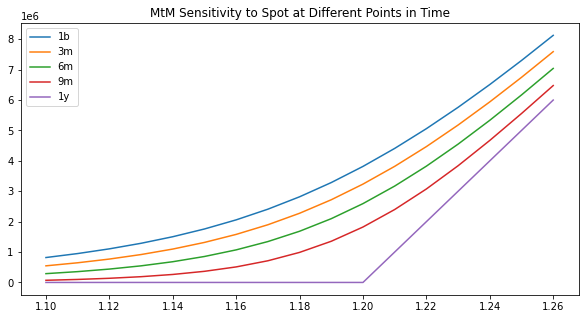

In [13]:
unbumped_vols = pd.DataFrame({t: {s: v[0].result() for s, v in i.items()} for t, i in call_res.items()})
unbumped_vols.plot(title='MtM Sensitivity to Spot at Different Points in Time', figsize=(10, 5))  

<AxesSubplot:title={'center':'MtM Sensitivity to Volatility Changes in 3 Months'}>

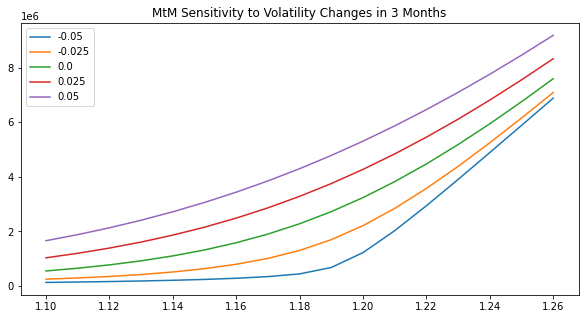

In [14]:
tenor_3m = pd.DataFrame({s: {b: r.result() for b, r in v.items()} for s, v in call_res['3m'].items()}).T
tenor_3m.plot(title='MtM Sensitivity to Volatility Changes in 3 Months', figsize=(10, 5))

As we can see above, with vol and/or spot higher, our call option's mark-to-market increases. We can use the prevaling option mtm to secure a rate on the forward - let's look at this next.

### 5 - Restructuring into a Forward

Now that we understand how the mark-to-market of the option may evolve into the future, let's analyze how this option (including the premium payable) can be restructured into a forward once the company get clarity on moving forward with the deal.

Specifically, let's assume there is clarity in 3 months and look at possible economics of unwinding the option after 3 months and using the mtm to finance a forward for the remaining 9 months.

As a first step, let's define our `FXForward` and calculate the implied forward rate for the 9-month remaining tenor at different spot levels using the `MarketDataShockBasedScenario`.

In [15]:
from gs_quant.instrument import FXForward

passed_time, remaining_time = '3m', '9m'
fxforward = FXForward(pair='EURUSD', settlement_date=remaining_time, notional_amount=100e6)
forward_res = {}
with PricingContext(market_data_location='NYC', is_batch=True):
    for s in spot_range:
        spot_scen = MarketDataShockBasedScenario(shocks={MarketDataPattern('FX', 'USD/EUR'): MarketDataShock(MarketDataShockType.Override, s),})
        with spot_scen:
            inst = fxforward.resolve(in_place=False)
        forward_res[s] = inst
forward_rates = pd.DataFrame({s: {'Forward Rate':  forward_res[s].result().forward_rate,
                                 'Option MTM ($)': call_res[passed_time][s][0].result()} for s in spot_range}).T

We can now calculate the adjustment to the forward rate based on the 3m in option mtm we calculated in the previous section (adjusting for the premium) and the above forward rate and examine how the achieved all-in rate on the forward may look like after the restructuring. 

Note two things here: (1) the premium payment for the option has been embedded into the new forward so the full structure is net zero premium (2) the below is an approximation that would work less well for currencies that have high carry, we are working on adding a forward rate solver to give a more precise answer.

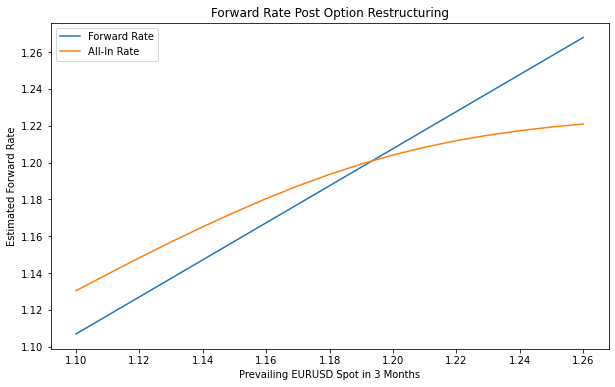

In [16]:
forward_rates['Forward Rate Adjustment'] = -1 * (forward_rates['Option MTM ($)'] - call_option.dollar_price()) / 100e6
forward_rates['All-In Rate'] = forward_rates['Forward Rate'] + forward_rates['Forward Rate Adjustment']
forward_rates[['Forward Rate', 'All-In Rate']].plot(title='Forward Rate Post Option Restructuring', figsize=(10, 6))  
plt.xlabel('Prevailing EURUSD Spot in 3 Months')
plt.ylabel('Estimated Forward Rate')
plt.show()

As we can see above, if the USD weakens vs EUR in 3 months time, the all-in rate will be lower (better) than the equivalent on-market forward - this is due to the EURUSD call option protection. However, if the dollar strenthens, the all-in rate will be higher (worse) than the on-market forward due to the premium payable for the option.

### What's New
* Ability to overwrite market data used in a risk request - example [here](https://nbviewer.jupyter.org/github/goldmansachs/gs-quant/blob/master/gs_quant/documentation/02_pricing_and_risk/00_instruments_and_measures/examples/00_instrument_basics/0005_market-data.ipynb)
* Restructuring of all notebooks into [documentation](https://nbviewer.jupyter.org/github/goldmansachs/gs-quant/tree/master/gs_quant/documentation/) and [content](https://nbviewer.jupyter.org/github/goldmansachs/gs-quant/tree/master/gs_quant/content/)
* Ability to use polling instead of websockets for batch mode (allowing python 3.6.0 support and cases where websockets may have firewall issues)